In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data

In [2]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

Half cheetah environment terminates automatically at 1000 timesteps.

In [3]:
import gym
num_rollouts = 20 # 20 * 1,000 = 20,000 training samples. should be fine..? 
env = gym.make("HalfCheetah-v4")

In [4]:
old_obs = []
actions = []
new_obs = []
for _ in range(num_rollouts):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        old_obs.append(obs)
        actions.append(action)
        new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

old_obs = np.vstack(old_obs)
actions = np.vstack(actions)
new_obs = np.vstack(new_obs)

/home/tristongrayston/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [5]:
old_obs.shape

(20000, 17)

In [6]:
inputs = np.concatenate((old_obs, actions), axis=1)
inputs.shape

(20000, 23)

In [39]:
inputs = torch.tensor(inputs)
outputs = torch.tensor(new_obs)
dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=64, shuffle=True, num_workers=8
)

/tmp/ipykernel_1623/243529121.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)


In [40]:
out_features = 17
in_features = 17 + 6

wiring = AutoNCP(64, out_features)  

world_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=20,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 28.1 K | train
---------------------------------------
22.5 K    Trainable params
5.6 K     Non-trainable params
28.1 K    Total params
0.112     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [12]:
# test set
t_old_obs = []
t_actions = []
t_new_obs = []
for _ in range(1):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation

        action = env.action_space.sample()
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        t_old_obs.append(obs)
        t_actions.append(action)
        t_new_obs.append(observation)
   
    # Once the episode is done, close the environment
    env.close()

t_old_obs = np.vstack(t_old_obs)
t_actions = np.vstack(t_actions)
t_new_obs = np.vstack(t_new_obs)
t_old_obs.shape

(1000, 17)

In [13]:
test_inputs = np.concatenate((t_old_obs, t_actions), axis=1)
test_inputs.shape
test_inputs = torch.tensor(test_inputs)

In [14]:
with torch.no_grad():
    prediction = world_model(test_inputs)[0].numpy()

prediction.shape

(1000, 17)

In [18]:
residuals = prediction - t_new_obs
residuals.shape

axis_avg = np.abs(np.average(residuals, axis=1))
axis_avg.shape

(1000,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


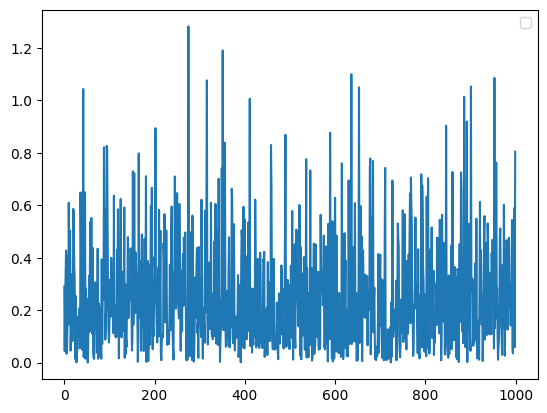

In [21]:
#for i in range(residuals.shape[1]):
#    plt.plot(residuals[:, i], label=f"Axis {i}")

plt.plot(axis_avg)

plt.legend()

In [31]:
dimension_descriptions = {
    0: "z-co-ord of the front tip ",
    1: "angle of the front tip",
    2: "angle of the second rotor 1 ",
    3: "angle of the second rotor 2 ",
    4: "velocity on tip along x-axis ",
    5: "velocity on tip along y-axis ",
    6: "ang velocity of front tip ",
    7: "ang velocity of second rotor ",
    8: "x-coord of the front tip (m)",
    9: "y-coord of the front tip (m)",
    10: "angle of the front tip",
    11: "angle of the second rotor",
    12: "angle of the second rotor",
    13: "velocity of the tip along the x-axis",
    14: "velocity of the tip along the y-axis",
    15: "angular velocity of front tip",
    16: "dimension 16 (fill in your description)",
}

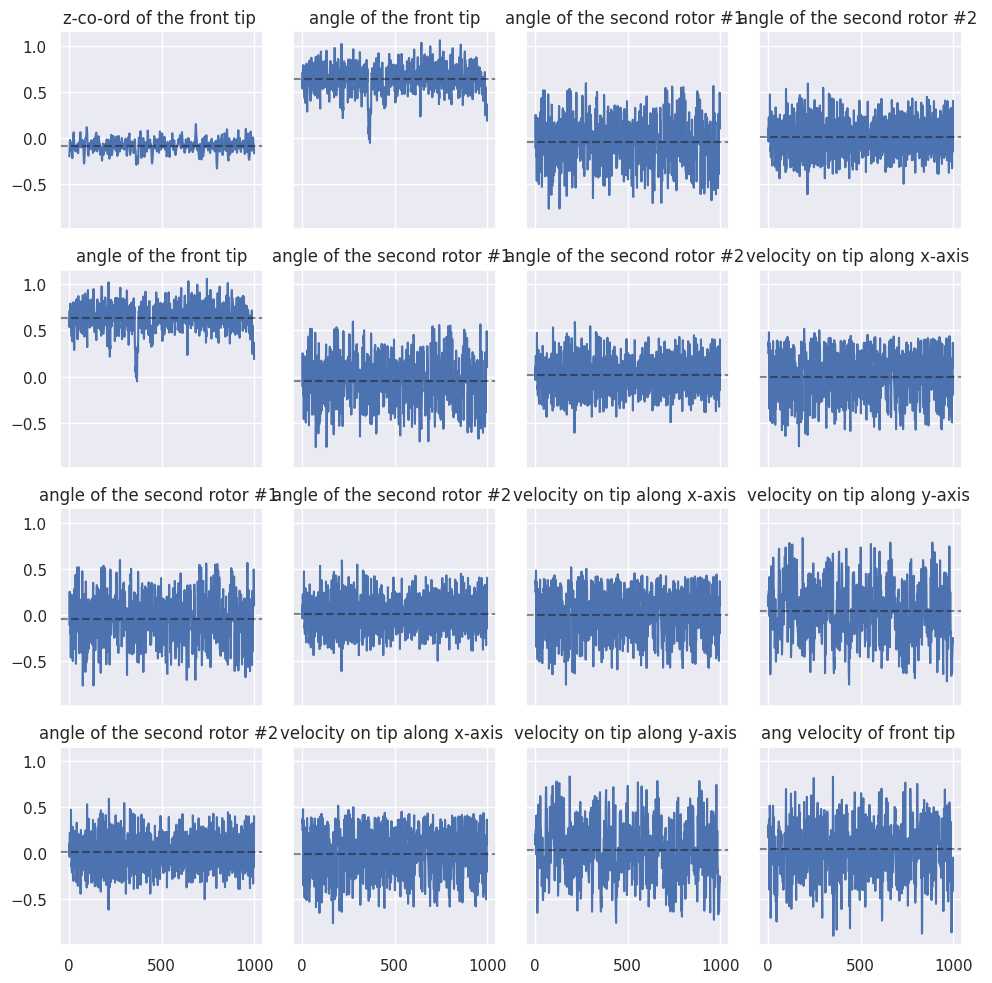

In [38]:
import seaborn as sns
sns.set()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), sharex=True, sharey=True)

# If you prefer a single row of 17 subplots horizontally,
# you would do: fig, axes = plt.subplots(nrows=1, ncols=17, figsize=(40, 4))

# Plot each dimension in a separate subplot
for j in range(4):
    for i in range(4):
        axes[j, i].plot(residuals[:, j + i])
        # get mean
        mean = np.mean(residuals[:, j + i])
        axes[j, i].axhline(mean,ls='--',c='k',alpha=0.5)

        
        axes[j, i].set_title(dimension_descriptions[j + i])

plt.tight_layout()
plt.show()